<a href="https://colab.research.google.com/github/Krishnaugale353/TB_detection/blob/main/tb_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import numpy as np
from pathlib import Path
import cv2
import math
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections.abc import Iterable
import glob

In [12]:
batch_size=30
patch_size=16
img_size=224
num_patches=(img_size//patch_size)**2
p_dim=768
heads_att=12
num_encoder=12

In [13]:
target_class={0:"Normal",1:"Tuberculosis"}
Normal_dir=Path("/content/drive/MyDrive/archive/TB_Chest_Radiography_Database/Normal")
TB_dir=Path("/content/drive/MyDrive/archive/TB_Chest_Radiography_Database/Tuberculosis")

In [14]:
Normal_images:list=sorted(list(map(str, list(Normal_dir.glob("*.png")))))
TB_images:list=sorted(list(map(str, list(TB_dir.glob("*.png")))))
Normal_labels:list=[0]*len(Normal_images)
TB_labels:list=[1]*len(TB_images)

In [15]:
images=np.array(Normal_images+TB_images)
labels=np.array(Normal_labels+TB_labels)
images.shape, labels.shape

((4200,), (4200,))

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(images,labels,test_size=0.2,random_state=42)
x_valid,x_test,y_valid,y_test=train_test_split(x_valid,y_valid,test_size=0.5,random_state=42)
(x_train.shape,x_valid.shape,x_test.shape)

((3360,), (420,), (420,))

In [17]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    clahe=cv2.createCLAHE(clipLimit=2)
    img=clahe.apply(img)
    img=cv2.GaussianBlur(img,(5,5),0,borderType=cv2.BORDER_CONSTANT)
    img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_LINEAR)
    img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img=np.moveaxis(img,-1,0)
    return img

In [18]:
!nvidia-smi

Wed Mar  6 05:20:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
x_train=np.array(list(map(image_preprocessing,x_train))).astype(np.float32)
x_valid=np.array(list(map(image_preprocessing,x_valid))).astype(np.float32)
x_test=np.array(list(map(image_preprocessing,x_test))).astype(np.float32)
x_train.shape,x_valid.shape,x_test.shape

((3360, 3, 224, 224), (420, 3, 224, 224), (420, 3, 224, 224))

In [20]:
device=("cuda" if torch.cuda.is_available() else "cpu")
x_train=torch.from_numpy(x_train).to(device)
x_valid=torch.from_numpy(x_valid).to(device)
x_test=torch.from_numpy(x_test).to(device)
y_train=torch.from_numpy(y_train).to(device)
y_valid=torch.from_numpy(y_valid).to(device)
y_test=torch.from_numpy(y_test).to(device)

In [21]:
class StandardScaler():
    def __init__(self) -> None:
        self.mean=None
        self.std=None
    def fit(self,tensor:torch.Tensor) -> None:
        self.mean=tensor.mean((0,2,3),keepdim=True)
        self.std=tensor.std((0,2,3),keepdim=True)
    def transform(self,tensor:torch.Tensor) -> torch.Tensor:
        scaled=(tensor-self.mean)/(self.std+1e-5)
        return scaled
    def fit_transform(self,tensor:torch.Tensor) -> torch.Tensor:
        self.fit(tensor=tensor)
        scaled=self.transform(tensor=tensor)
        return scaled

In [22]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)

In [23]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [24]:
train_dataset=TensorDataset(x_train,y_train)
val_dataset=TensorDataset(x_valid,y_valid)
test_dataset=TensorDataset(x_test,y_test)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [25]:
def extract_image_patches(x:torch.Tensor, kernel:int, stride:int=1, dilation:int=1):

    b,c,h,w = x.shape
    h2 = math.ceil(h / stride)
    w2 = math.ceil(w / stride)
    pad_row = (h2 - 1) * stride + (kernel - 1) * dilation + 1 - h
    pad_col = (w2 - 1) * stride + (kernel - 1) * dilation + 1 - w
    x = torch.nn.functional.pad(x, (pad_row//2, pad_row - pad_row//2, pad_col//2, pad_col - pad_col//2))

    # Extract patches
    patches = x.unfold(2, kernel, stride).unfold(3, kernel, stride)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(*patches.size()[:3], -1)

    #flatten patches
    return patches.view(b,-1,patches.shape[-1])

In [26]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, projection_dim:int, num_heads:int, num_patches:int):
        super().__init__()
        self.projection_dim=projection_dim
        self.num_heads=num_heads
        self.num_patches=num_patches

        self.norm1=torch.nn.LayerNorm(self.projection_dim)
        self.norm2=torch.nn.LayerNorm(self.projection_dim)
        self.attention=torch.nn.MultiheadAttention(self.projection_dim,self.num_heads,batch_first=True)
        self.mlp=torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim,self.projection_dim*4),
            torch.nn.GELU(),
            torch.nn.Linear(self.projection_dim*4,self.projection_dim),
        )

    def forward(self,x):
        x1=self.norm1(x)
        attention=self.attention(x1,x1,x1)[0]
        x2=attention+x
        x3=self.norm2(x2)
        x3=self.mlp(x3)
        out=x2+x3
        return out

In [27]:
class PEG(torch.nn.Module):
    def __init__(self,dim:int,k:int=3):
        super().__init__()
        self.pos=torch.nn.Conv2d(dim,dim,k,1,1,groups=dim)
    def forward(self,x,H,W):
        B,N,C=x.shape
        feat_tokens=x
        feat_tokens=feat_tokens.transpose(1,2).view(B,C,H,W)
        x=self.pos(feat_tokens)+feat_tokens
        x=x.flatten(2).transpose(1,2)
        return x

In [28]:
class ViT(torch.nn.Module):
    def __init__(self,
                 patch_size:int,
                 num_patches:int,
                 projection_dim:int,
                 num_heads:int,
                 num_encoder:int):
        super().__init__()
        self.patch_size=patch_size
        self.num_patches=num_patches
        self.projection_dim=projection_dim
        self.num_heads=num_heads
        self.num_encoder=num_encoder

        self.input_d=self.patch_size*self.patch_size*3
        self.linear=torch.nn.Linear(self.input_d,self.projection_dim)
        self.peg=PEG(self.projection_dim,3)
        self.blocks = torch.nn.ModuleList([
            EncoderBlock(self.projection_dim, self.num_heads, self.num_patches) for _ in range(self.num_encoder)
        ])
        self.ln_out=torch.nn.LayerNorm(self.projection_dim)

        self.out=torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim,1),
            torch.nn.Sigmoid()
        )
    def forward(self,images:torch.Tensor):
        batch_size=images.size()[0]
        x=extract_image_patches(images,self.patch_size,self.patch_size)
        x=self.linear(x)
        encoded=x

        for i,block in enumerate(self.blocks):
            encoded=block(encoded)
            if i==0:
                _H,_W=int(self.num_patches**0.5),int(self.num_patches**0.5)
                encoded=self.peg(encoded,_H,_W)

        rep=encoded.mean(dim=1)
        rep=self.ln_out(rep)
        output=self.out(rep)
        return output

In [29]:
model=ViT(patch_size=patch_size,
          num_patches=num_patches,
          projection_dim=p_dim,
          num_heads=heads_att,
          num_encoder=num_encoder).to(device)
print(model)

ViT(
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (peg): PEG(
    (pos): Conv2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=768)
  )
  (blocks): ModuleList(
    (0-11): 12 x EncoderBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (ln_out): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (out): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [30]:
vit_total_params = sum(p.numel() for p in model.parameters())
vit_total_params

85655041

In [31]:
epoch=30
loss_fn=torch.nn.BCELoss()
opt=torch.optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt,T_max=epoch,verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [32]:
best_loss = float('inf')
best_model_weights = None
patience=10
for i in range(epoch):
    print(f"Epoch: {i+1}\n")
    model.train()
    train_loss=0
    train_batches=len(train_loader)
    for batch,(x,y) in enumerate(train_loader):
        pred=model(x).squeeze(-1)
        loss=loss_fn(pred,y.float())
        train_loss+=loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
    train_loss/=train_batches
    print(f"Train Error: \n Avg loss: {train_loss:>8f} \n")
    model.eval()
    test_loss=0
    test_batches=len(val_loader)
    with torch.no_grad():
        for x,y in val_loader:
            pred=model(x).squeeze(-1)
            test_loss += loss_fn(pred,y.float()).item()
    test_loss /= test_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    if test_loss<best_loss:
        best_loss=test_loss
        best_model_weights=model.state_dict()
        patience=10
    else:
        patience-=1
        if patience==0:
            break
    scheduler.step()
model.load_state_dict(best_model_weights)
print(f'best loss:', best_loss)

Epoch: 1

Train Error: 
 Avg loss: 0.385854 

Test Error: 
 Avg loss: 0.269744 

Adjusting learning rate of group 0 to 9.9726e-04.
Epoch: 2

Train Error: 
 Avg loss: 0.301950 

Test Error: 
 Avg loss: 0.206855 

Adjusting learning rate of group 0 to 9.8907e-04.
Epoch: 3

Train Error: 
 Avg loss: 0.245066 

Test Error: 
 Avg loss: 0.172356 

Adjusting learning rate of group 0 to 9.7553e-04.
Epoch: 4

Train Error: 
 Avg loss: 0.199868 

Test Error: 
 Avg loss: 0.229386 

Adjusting learning rate of group 0 to 9.5677e-04.
Epoch: 5

Train Error: 
 Avg loss: 0.164345 

Test Error: 
 Avg loss: 0.143878 

Adjusting learning rate of group 0 to 9.3301e-04.
Epoch: 6

Train Error: 
 Avg loss: 0.117842 

Test Error: 
 Avg loss: 0.106918 

Adjusting learning rate of group 0 to 9.0451e-04.
Epoch: 7

Train Error: 
 Avg loss: 0.104704 

Test Error: 
 Avg loss: 0.101112 

Adjusting learning rate of group 0 to 8.7157e-04.
Epoch: 8

Train Error: 
 Avg loss: 0.105941 

Test Error: 
 Avg loss: 0.100986 

Ad

In [33]:
model.eval()
val_preds=[]
with torch.no_grad():
    for x,y in val_loader:
        pred=model(x).squeeze(-1)
        val_preds.append(pred.cpu().numpy())
val_preds=np.concatenate(val_preds,axis=0)
val_preds=np.round(val_preds)
recall_score(y_valid.cpu().numpy(),val_preds),accuracy_score(y_valid.cpu().numpy(),val_preds)

(0.9436619718309859, 0.9833333333333333)

In [34]:
model.eval()
test_preds=[]
with torch.no_grad():
    for x,y in test_loader:
        pred=model(x).squeeze(-1)
        test_preds.append(pred.cpu().numpy())
test_preds=np.concatenate(test_preds,axis=0)
test_preds=np.round(test_preds)
recall_score(y_test.cpu().numpy(),test_preds),accuracy_score(y_test.cpu().numpy(),test_preds)

(0.9090909090909091, 0.9833333333333333)


------------------------Confusion Matrix - Validation Dataset------------------------


Accuracy: 0.9833 (98.33%)

Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       349
           1       0.96      0.94      0.95        71

    accuracy                           0.98       420
   macro avg       0.97      0.97      0.97       420
weighted avg       0.98      0.98      0.98       420

--------------------------------------------------------------------------


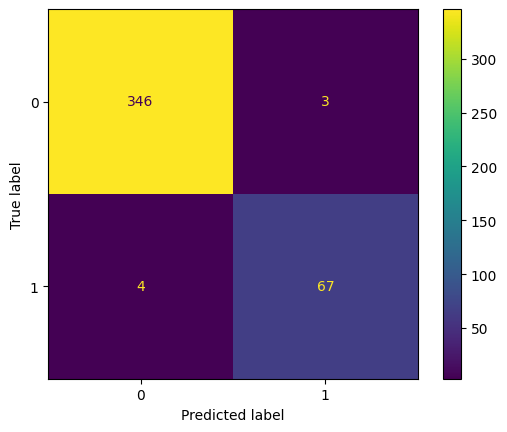

In [36]:
def evaluation_parametrics(name,y_val, y_pred):

    print("\n------------------------{}------------------------\n".format(name))

    cm_test = confusion_matrix(y_val, y_pred)
    t1 = ConfusionMatrixDisplay(cm_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred))
    print("--------------------------------------------------------------------------")

    t1.plot()
evaluation_parametrics("Confusion Matrix - Validation Dataset", y_valid.cpu().numpy(), val_preds)

In [37]:
def save_model(model, filename):
  """Saves the PyTorch model to the specified file.

  Args:
      model: The PyTorch model to save.
      filename: The filename to save the model to.
  """
  torch.save(model.state_dict(), filename)
  print(f"Model saved successfully to: {filename}")


In [38]:
filename = "/content/drive/MyDrive/archive/TB_Chest_Radiography_Database/krish.pth"  # Example filename


In [39]:
# Train your model... (assuming you have a trained model)

save_model(model, filename)


Model saved successfully to: /content/drive/MyDrive/archive/TB_Chest_Radiography_Database/krish.pth


In [46]:
import torch

def load_model(filename):
  """Loads a PyTorch model from the specified file.

  Args:
      filename: The filename from which to load the model.

  Returns:
      The loaded PyTorch model.
  """
  model = ViT(  # Replace with your actual values if necessary
    patch_size=16,
    num_patches=196,
    projection_dim=768,
    num_heads=12,
    num_encoder=12
  )

  model.load_state_dict(torch.load(filename))
  print(f"Model loaded successfully from: {filename}")
  return model


In [47]:
# Example usage:
loaded_model = load_model("/content/drive/MyDrive/archive/TB_Chest_Radiography_Database/krish.pth")


Model loaded successfully from: /content/drive/MyDrive/archive/TB_Chest_Radiography_Database/krish.pth
